In [1]:
import sys, os, time

sys.path.append(os.path.join("..", "src"))

import numpy as np
import jax.numpy as jnp
import pandas as pd

from systems import HopfDefinition
from sindy_core import SINDyConfig
from run_model import (
    run_sindy_experiment,
    load_experiment,
    make_composite_figure,
    print_equations_from_result,
)

In [ ]:
# 1. Hopf parameters and problem definition
hopf_params = {
    "mu": 1.0,
    "omega": 1.0,
}

hopf_problem = HopfDefinition(
    parameters=hopf_params,
    x0_vector=jnp.array([2.0, 0.0]),  # starts outside the limit cycle
    t0=0.0,
    tf=20.0,
    dt=0.01,
)

# 2. SINDy config: cubic polynomial, pruned STLSQ, no normalization
cfg_hopf = SINDyConfig(
    poly_degree=3,  
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y"),
    mode="polynomial",
    normalize=False,
    stlsq_mode="pruned",
)

cfg_hopf

SINDyConfig(poly_degree=3, include_bias=True, threshold=0.1, n_iter=10, post_tol=0.01, var_names=('x', 'y'), normalize=False, mode='polynomial', k_max=0, include_sin=True, include_cos=True, fourier_prefix='t', stlsq_mode='pruned')

Saved: ../outputs/Hopf\Hopf_fd_noise0.000.npz
[Hopf clean] finished in 42.46 seconds
Saved to: ../outputs/Hopf\Hopf_fd_noise0.000.npz
Hopf (fd, noise=0.000)

True system:
dx/dt = 1*x - 1*y - (x^2 + y^2)*x
dy/dt = 1*x + 1*y - (x^2 + y^2)*y

SINDy model:
dx/dt = 1.00177*x - 0.99996*y - 1.00172*x^3 - 1.00172*x y^2
dy/dt = 0.999998*x + 0.999264*y - 0.999277*x^2 y - 0.999271*y^3


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


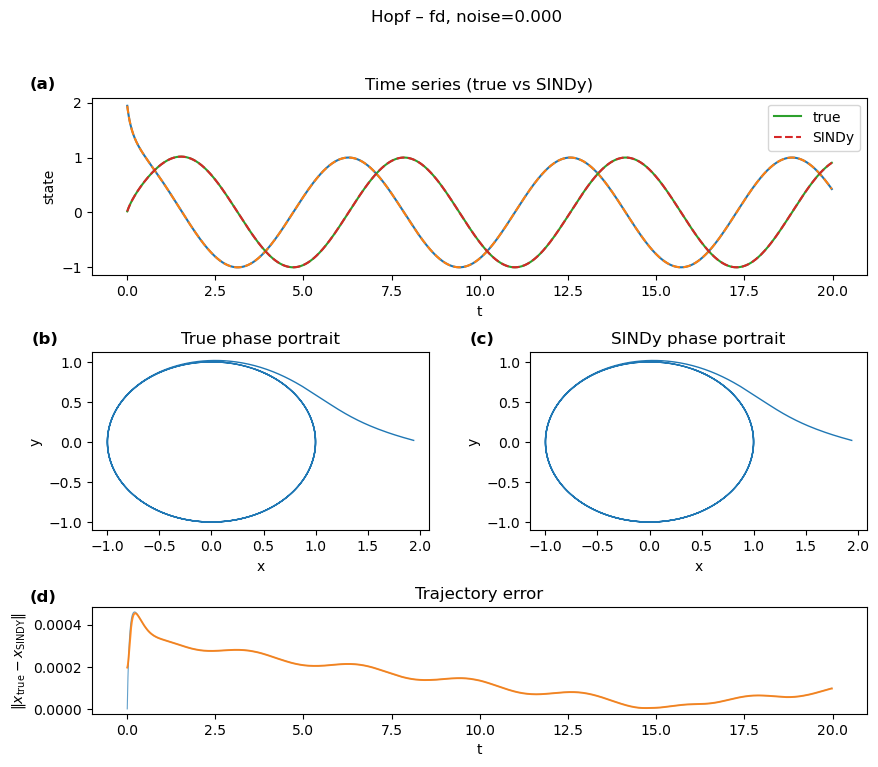

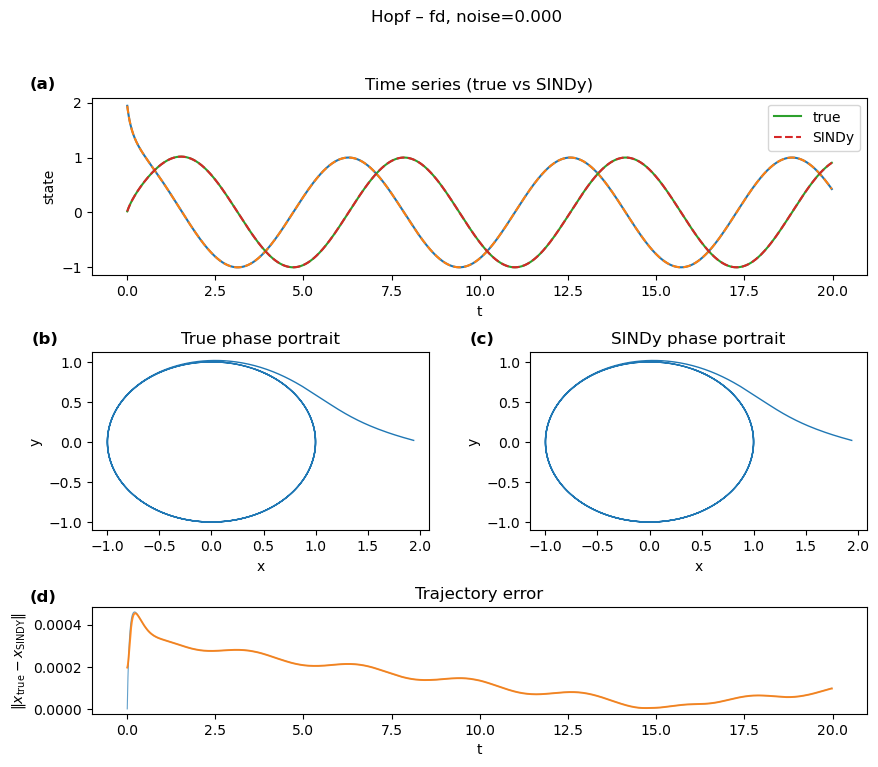

In [ ]:
FIG_DIR = "../figs"
OUT_HOPF = "../outputs/Hopf"

os.makedirs(FIG_DIR, exist_ok=True)

# 3. Run one experiment: derivative choice and noise level
DERIV_KEY_HOPF = "fd"

t0_run = time.perf_counter()
hopf_path = run_sindy_experiment(
    problem=hopf_problem,
    deriv_key=DERIV_KEY_HOPF,
    noise_level=0.0,
    sindy_config=cfg_hopf,
    outdir=OUT_HOPF,
    drop_transient=0.0,
)
elapsed = time.perf_counter() - t0_run

print(f"[Hopf clean] finished in {elapsed:.2f} seconds")
print("Saved to:", hopf_path)

hopf_result = load_experiment(hopf_path)
print_equations_from_result(hopf_result)

# 4. Composite figure: time series + phase + error
fig_hopf, axes_hopf = make_composite_figure(
    hopf_result,
    phase_i=0,  # x
    phase_j=1,  # y
    labels=["x", "y"],
)

fig_hopf.savefig(
    os.path.join(FIG_DIR, f"hopf_{DERIV_KEY_HOPF}_clean_composite.png"),
    dpi=300,
    bbox_inches="tight",
)
fig_hopf

In [4]:
def build_hopf_coeff_table(result, params):
    """
    Build table comparing SINDy coefficients to analytic Hopf coefficients
    for poly_degree=3 with var_names=("x","y").
    """
    feature_names = [str(s) for s in result["feature_names"]]
    Xi = np.asarray(result["Xi"])  # shape (n_features, 2)

    mu = float(params["mu"])
    omega = float(params["omega"])

    n_feat = len(feature_names)
    true_coeffs = np.zeros((n_feat, 2))

    # Fill analytic coefficients
    for i, name in enumerate(feature_names):
        # dx/dt:
        #   μ x  -> +mu * x
        #  -ω y  -> -omega * y
        #  -x^3  -> -1 * x^3
        #  -x y^2 -> -1 * x y^2
        if name == "x":
            true_coeffs[i, 0] += mu
        elif name == "y":
            true_coeffs[i, 0] += -omega
        elif name == "x^3":
            true_coeffs[i, 0] += -1.0
        elif name == "x y^2":
            true_coeffs[i, 0] += -1.0

        # dy/dt:
        #   ω x   -> +omega * x
        #   μ y   -> +mu * y
        #  -x^2 y -> -1 * x^2 y
        #  -y^3   -> -1 * y^3
        if name == "x":
            true_coeffs[i, 1] += omega
        elif name == "y":
            true_coeffs[i, 1] += mu
        elif name == "x^2 y":
            true_coeffs[i, 1] += -1.0
        elif name == "y^3":
            true_coeffs[i, 1] += -1.0

    diff = Xi - true_coeffs

    df = pd.DataFrame(
        {
            "feature": feature_names,
            "dx_true": true_coeffs[:, 0],
            "dx_SINDy": Xi[:, 0],
            "dx_diff": diff[:, 0],
            "dy_true": true_coeffs[:, 1],
            "dy_SINDy": Xi[:, 1],
            "dy_diff": diff[:, 1],
        }
    )

    return df


hopf_coeff_table = build_hopf_coeff_table(hopf_result, hopf_params)
hopf_coeff_table.round(4)

,feature,dx_true,dx_SINDy,dx_diff,dy_true,dy_SINDy,dy_diff
0,1,0.0,0.0000,0.0000,0.0,0.0000,0.0000
1,x,1.0,1.0018,0.0018,1.0,1.0000,-0.0000
2,y,-1.0,-1.0000,0.0000,1.0,0.9993,-0.0007
3,x^2,0.0,0.0000,0.0000,0.0,0.0000,0.0000
4,x y,0.0,0.0000,0.0000,0.0,0.0000,0.0000
5,y^2,0.0,0.0000,0.0000,0.0,0.0000,0.0000
6,x^3,-1.0,-1.0017,-0.0017,0.0,0.0000,0.0000
7,x^2 y,0.0,0.0000,0.0000,-1.0,-0.9993,0.0007
8,x y^2,-1.0,-1.0017,-0.0017,0.0,0.0000,0.0000
9,y^3,0.0,0.0000,0.0000,-1.0,-0.9993,0.0007


In [ ]:
hopf_coeff_table.round(4).to_csv(
    os.path.join(FIG_DIR, f"hopf_{DERIV_KEY_HOPF}_clean_coeffs.csv"),
    index=False,
)

In [ ]:
import matplotlib.pyplot as plt

# 5. μ sweep for Hopf phase-slice plots
MU_VALUES = [-0.1, 0.0, 0.2, 0.4, 0.6]
DERIV_KEY_HOPF = "fd"  
NOISE_MU = 0.05  # relative noise level for the "noisy measurement" style

OUT_HOPF_MU = "../outputs/Hopf_mu_sweep"
os.makedirs(OUT_HOPF_MU, exist_ok=True)

hopf_mu_results = {}  # store loaded results keyed by μ

for mu in MU_VALUES:
    params_mu = {"mu": float(mu), "omega": hopf_params["omega"]}
    hopf_mu = HopfDefinition(
        parameters=params_mu,
        x0_vector=jnp.array([2.0, 0.0]),
        t0=0.0,
        tf=20.0,
        dt=0.01,
    )

    outdir_mu = os.path.join(OUT_HOPF_MU, f"mu_{mu:+.2f}")
    os.makedirs(outdir_mu, exist_ok=True)

    print(f"\n[Hopf μ = {mu:+.2f}] running SINDy experiment...")
    t0_run = time.perf_counter()
    path_mu = run_sindy_experiment(
        problem=hopf_mu,
        deriv_key=DERIV_KEY_HOPF,
        noise_level=NOISE_MU,
        sindy_config=cfg_hopf,
        outdir=outdir_mu,
        drop_transient=0.0,
    )
    elapsed_mu = time.perf_counter() - t0_run
    print(f"  finished in {elapsed_mu:.2f} s -> {path_mu}")

    hopf_mu_results[mu] = load_experiment(path_mu)


[Hopf μ = -0.10] running SINDy experiment...
Saved: ../outputs/Hopf_mu_sweep\mu_-0.10\Hopf_fd_noise0.050.npz
  finished in 42.07 s -> ../outputs/Hopf_mu_sweep\mu_-0.10\Hopf_fd_noise0.050.npz

[Hopf μ = +0.00] running SINDy experiment...
Saved: ../outputs/Hopf_mu_sweep\mu_+0.00\Hopf_fd_noise0.050.npz
  finished in 42.26 s -> ../outputs/Hopf_mu_sweep\mu_+0.00\Hopf_fd_noise0.050.npz

[Hopf μ = +0.20] running SINDy experiment...
Saved: ../outputs/Hopf_mu_sweep\mu_+0.20\Hopf_fd_noise0.050.npz
  finished in 46.41 s -> ../outputs/Hopf_mu_sweep\mu_+0.20\Hopf_fd_noise0.050.npz

[Hopf μ = +0.40] running SINDy experiment...
Saved: ../outputs/Hopf_mu_sweep\mu_+0.40\Hopf_fd_noise0.050.npz
  finished in 41.77 s -> ../outputs/Hopf_mu_sweep\mu_+0.40\Hopf_fd_noise0.050.npz

[Hopf μ = +0.60] running SINDy experiment...
Saved: ../outputs/Hopf_mu_sweep\mu_+0.60\Hopf_fd_noise0.050.npz
  finished in 44.45 s -> ../outputs/Hopf_mu_sweep\mu_+0.60\Hopf_fd_noise0.050.npz


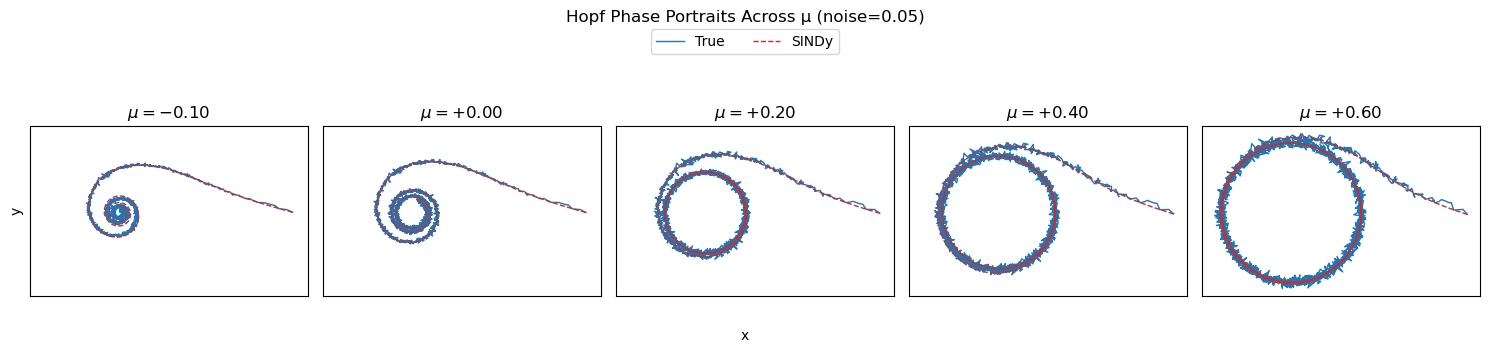

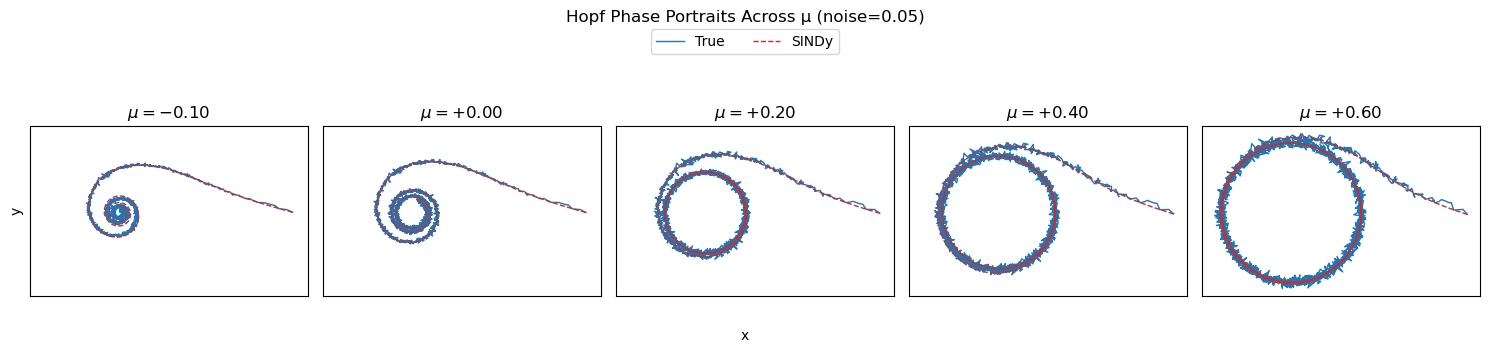

In [7]:
fig, axes = plt.subplots(
    1,
    len(MU_VALUES),
    figsize=(3.0 * len(MU_VALUES), 3.0),
    sharex=True,
    sharey=True,
)

if len(MU_VALUES) == 1:
    axes = [axes]

for ax, mu in zip(axes, MU_VALUES):
    res = hopf_mu_results[mu]

    X_true = np.asarray(res["xs_true_seg"])  # true data used for fit
    X_sindy = np.asarray(res["xs_sindy"])  # SINDy reconstruction

    # True (noisy) measurements in blue
    ax.plot(
        X_true[:, 0],
        X_true[:, 1],
        lw=1.0,
        color="C0",
        label="True" if mu == MU_VALUES[0] else None,
    )
    # Identified model in red
    ax.plot(
        X_sindy[:, 0],
        X_sindy[:, 1],
        lw=1.0,
        color="C3",
        linestyle="--",
        label="SINDy" if mu == MU_VALUES[0] else None,
    )

    ax.set_title(rf"$\mu = {mu:+.2f}$")
    ax.set_aspect("equal", "box")
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_ylabel("y")
fig.text(0.5, 0.02, "x", ha="center")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.08)
    )

fig.suptitle(f"Hopf Phase Portraits Across μ (noise={NOISE_MU:.2f})", y=1.12)

fig.tight_layout()

fig.savefig(
    os.path.join(
        FIG_DIR, f"hopf_mu_slices_true_vs_sindy_noise{NOISE_MU:.2f}.png"
    ),
    dpi=300,
    bbox_inches="tight",
)
fig